In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from scipy.ndimage import gaussian_filter1d

import corner

import os

import requests

from hyperfit.linfit import LinFit

from desispec.io import read_spectra
from desispec.spectra import stack as specstack
from desispec.coaddition import coadd_cameras

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

# Data

## fuji

In [3]:
#tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits') # <-- CORI
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


### Separate the fuji data into center and off-center observations

In [4]:
def firstdigit(n):
    """
    Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    
    digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)
    
    return digit

In [5]:
first_digits = firstdigit(tfuji['TARGETID'])

fuji_centers = tfuji[first_digits == 3]
fuji_axis = tfuji[first_digits != 3]

/tmp/ipykernel_29409/917620242.py:16: RuntimeWarning: invalid value encountered in log10
  digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)


### Clean the fuji center observations

Only keep those with
 * DELTACHI2 > 25
 * ZWARN == 0

In [6]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

#### Are there any galaxies with multiple good center observations?

In [7]:
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

print(unique_ids[counts > 1], counts[counts > 1])

 SGA_ID
-------
    848
   3727
  26199
  37543
  46327
  83216
  98934
 100987
 101569
 102832
    ...
1204188
1244275
1249892
1272144
1273084
1284002
1285273
1319490
1366241
1380792
1382772
Length = 87 rows [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


## SGA

In [8]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [9]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [10]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the average redshift of all good center observations
    SGA['Z_DESI'][SGA_idx] = np.mean(good_centers['Z'][good_centers['SGA_ID'] == sga_id])
    SGA['ZERR_DESI'][SGA_idx] = np.mean(good_centers['ZERR'][good_centers['SGA_ID'] == sga_id]**2)/np.sum(good_centers['SGA_ID'] == sga_id)

# Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [11]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [12]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]

In [13]:
# Data table #2 from Tully et al. (2013)
hdu = fits.open('../Tully13-Table2.fit')
table2 = Table(hdu[1].data)
hdu.close()

table2[:5]

_RAJ2000,_DEJ2000,N1,__Dist_,__DM_,__Err_,N2,GLON,GLAT,SGLON,SGLAT,GMT,__Bmag_,__Kmag_,__HV_,__GV_,__Vls_,__Vcmb_,__Vcmba_,sigma,__PV_,__PVa_,Group,Ng,_2M__,PGCb,GName,_2M,Simbad,NED,recno
float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,int32,int32,int32,int32,int32,int16,int32,int32,int16,int16,int16,int32,str10,str2,str6,str3,int32
266.404996,-28.936172,16,0.01,14.5,0.02,20,0.0,0.0,185.7861,42.3103,1,-6.0,-9.0,51,26,13,91,91,64,90,90,223,16,0,17223,Galaxy,2M,Simbad,NED,1
15.693346,36.392682,39,0.76,24.4,0.01,41,125.479,-26.423,322.2989,9.4579,2,3.4,0.68,-213,-49,17,-485,-484,156,-541,-547,222,39,0,2557,NGC0224,2M,Simbad,NED,2
149.896678,-12.831016,4,1.37,25.68,0.03,4,251.1365,32.2601,120.502,-42.5472,10,9.75,9.29,347,153,103,690,691,23,589,589,227,4,0,29128,NGC003109,2M,Simbad,NED,3
139.011477,52.840941,1,1.37,25.68,0.1,1,164.6636,42.8855,47.6118,-15.0125,10,13.75,11.5,-29,17,45,130,130,0,28,28,0,579,0,26142,UGC4879,2M,Simbad,NED,4
243.448636,54.37081,1,1.91,26.41,0.08,1,83.8788,44.4092,56.0935,40.37,10,16.69,12.9,-139,44,78,-121,-120,0,-262,-268,230,1,0,2801026,KKR25,2M,Simbad,NED,5


In [14]:
Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = Coma_coords.match_to_catalog_sky(group_coords)

V_Coma = table2['__HV_'][idx][0]

V_Coma

6899

## Calculate the projected distance between the Coma cluster and each SGA galaxy

In [15]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_Coma_angle = (R2t_Coma/(V_Coma/H0))*u.radian

In [16]:
SGA_coords = SkyCoord(SGA['RA'], SGA['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [17]:
SGA_in_Coma1 = (sep < 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 3*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (sep < 3*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA['SGA_ID'][SGA_in_Coma]

centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
print('fuji off-center observations in Coma:', len(axis_inComa))

fuji galaxies in Coma with good center observations: 272
fuji off-center observations in Coma: 941


In [25]:
Christoph_removed = np.in1d(SGA['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])

print(SGA_in_Coma1[Christoph_removed])
print(SGA_in_Coma2[Christoph_removed])

[ True False False  True False]
[False  True  True False  True]


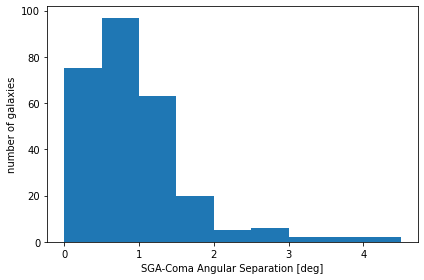

In [18]:
plt.figure(tight_layout=True)

plt.hist(sep[SGA_in_Coma].to_value('degree'), bins=np.arange(0, 5, 0.5))
#plt.hist(sep[np.in1d(SGA['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])].to_value('degree'), bins=np.arange(0, 5, 0.5))

plt.xlabel('SGA-Coma Angular Separation [deg]')
plt.ylabel('number of galaxies');

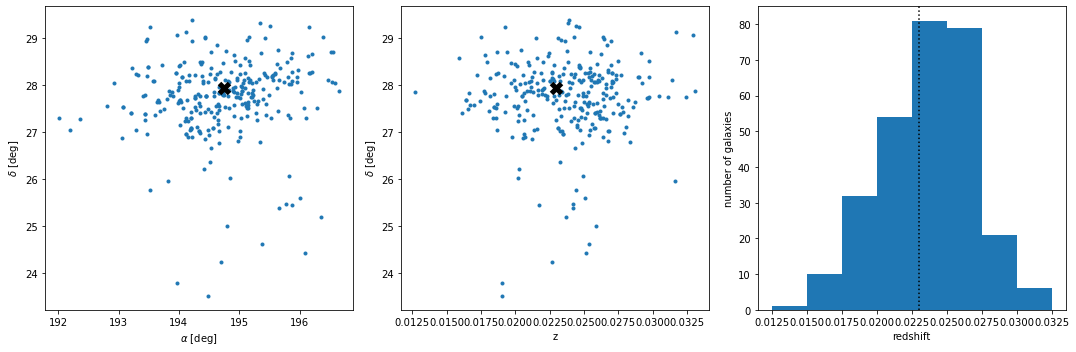

In [19]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_inComa['TARGET_RA'], centers_inComa['TARGET_DEC'], '.')
# plt.plot(centers_inComa['TARGET_RA'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
#          centers_inComa['TARGET_DEC'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])],
#          'o')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_inComa['Z'], centers_inComa['TARGET_DEC'], '.')
# plt.plot(centers_inComa['Z'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
#          centers_inComa['TARGET_DEC'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])],
#          'o')
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_inComa['Z'], bins=np.arange(0.0125, 0.035, 0.0025))
# plt.hist(centers_inComa['Z'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], bins=np.arange(0.0125, 0.035, 0.0025))
plt.vlines(V_Coma/c, 0, 85, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=85);

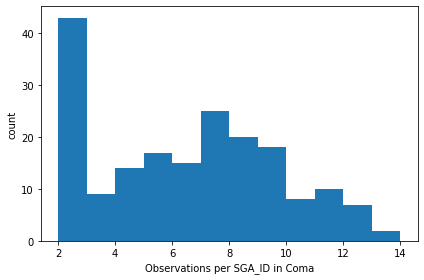

In [20]:
axis_SGAids, axis_counts = np.unique(axis_inComa['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_inComa['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Coma:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Coma')
plt.ylabel('count');

# Calculate the rotational velocity

In [21]:
axis_inComa['SKY_FIBER_DIST'] = 0.
axis_inComa['SKY_FIBER_DIST_R26'] = 0.
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_inComa['RA'][obs_idx], 
                             dec=axis_inComa['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_inComa['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_inComa['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

/tmp/ipykernel_29409/2270156695.py:56: RuntimeWarning: divide by zero encountered in true_divide
  axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))


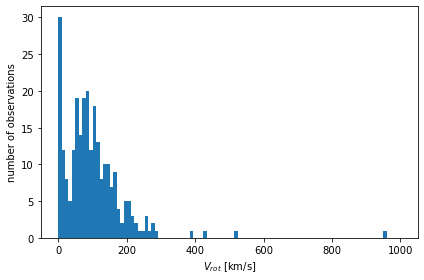

In [22]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_inComa['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for Coma galaxies suitable for calibrating the TFR

Requirements:
 * $V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [23]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = np.abs(axis_inComa['V_ROT']) < 1000

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

198 116


## Inclination angle cut

In [24]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_axis_inComa['iSGA'] = -1

for i in range(len(good_axis_inComa)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_axis_inComa['SGA_ID'][i]]
    
    good_axis_inComa['iSGA'][i] = sga_idx
    
good_axis_inComa['cosi2'] = SGA['cosi2'][good_axis_inComa['iSGA']]

In [25]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_axis_inComa['cosi2'] <= cosi2_max

good_edge_axis_inComa = good_axis_inComa[edge]

print(len(good_edge_axis_inComa), len(np.unique(good_edge_axis_inComa['SGA_ID'])))

155 93


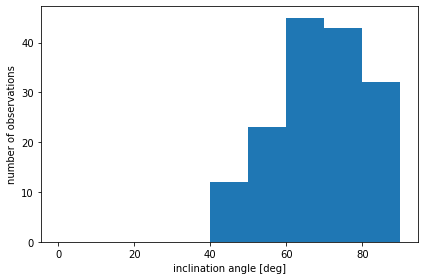

In [26]:
plt.figure(tight_layout=True)

plt.hist(np.arccos(np.sqrt(good_edge_axis_inComa['cosi2']))*180/np.pi, bins=np.linspace(0, 90, 10))

plt.xlabel('inclination angle [deg]')
plt.ylabel('number of observations');

## Morphology cut

In [27]:
good_edge_axis_inComa['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_inComa['iSGA']]

In [28]:
spirals = np.zeros(len(good_edge_axis_inComa), dtype=bool)

for i in range(len(good_edge_axis_inComa)):
    
    try:    
        if (good_edge_axis_inComa['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_inComa['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_inComa['MORPHTYPE'][i])

good_edge_spirals_axis_inComa = good_edge_axis_inComa[spirals]

print(len(good_edge_spirals_axis_inComa), len(np.unique(good_edge_spirals_axis_inComa['SGA_ID'])))

--
--
--
84 47


## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [29]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

cache/coma_39627776214435213.jpg exists.
INFO:spectra.py:291:read_spectra: iotime 4.317 sec to read spectra-sv3-bright-26004.fits at 2022-09-02T16:10:03.413145


TypeError: 'AxesSubplot' object is not subscriptable

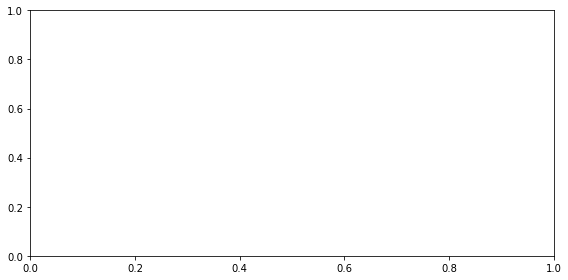

In [183]:
for sga_id in np.unique(good_edge_spirals_axis_inComa['SGA_ID']):
    
    tf_list = good_edge_spirals_axis_inComa[good_edge_spirals_axis_inComa['SGA_ID'] == sga_id]
    center_list = centers_inComa[centers_inComa['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    
    break

In [29]:
VI_remove = Table.read('fuji_Coma_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_inComa), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_inComa['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_inComa = good_edge_spirals_axis_inComa[~remove_targets]

print(len(VI_good_edge_spirals_axis_inComa), len(np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID'])))

84 47


# Coma TFR

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [30]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_inComa['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_inComa['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [31]:
# Make a catalog of just those galaxies with velocities
SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

# Christoph_removed = np.in1d(SGA_TF['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])

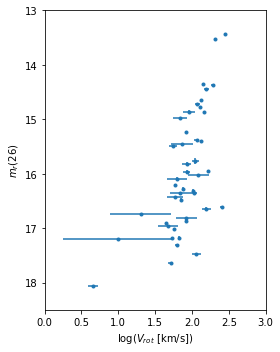

In [32]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.')
# plt.errorbar(np.log10(SGA_TF['V_0p33R26'][Christoph_removed]), 
#              SGA_TF['R_MAG_SB26'][Christoph_removed], 
#              xerr=0.434*SGA_TF['V_0p33R26_err'][Christoph_removed]/SGA_TF['V_0p33R26'][Christoph_removed],
#              yerr=SGA_TF['R_MAG_SB26_ERR'][Christoph_removed], 
#              fmt='.')

plt.xlim([0, 3])
plt.ylim([18.5, 13])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

## Remove dwarf galaxies

This is to mimic the selection criteria used in the Cosmicflows-4 calibration, and is only possible after a full calibration has been done.  This is therefore an iterative process.

### First, calculate the absolute magnitudes for the galaxies based on the current TF calibration

\begin{equation}
  M_r = a\log \left( V(0.33R_{26}) \right) + b
\end{equation}
where
* $a = -5.63^{+0.87}_{-1.19}$ (from `Coma-Fuji_KAD.ipynb`)
* $b = -7.93\pm 2.71$ (from `fuji_zero-point_KAD.ipynb`)

In [33]:
our_slope = -5.63
our_slope_err = 1.16

our_ZP = -7.93
our_ZP_err = 2.71

SGA_TF['R_ABSMAG_SB26'] = our_slope*np.log10(SGA_TF['V_0p33R26']) + our_ZP

In [60]:
N_samples = 100000

rng = np.random.default_rng()

m_random = rng.normal(our_slope, our_slope_err, size=N_samples)
b_random = rng.normal(our_ZP, our_ZP_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m_random*np.log10(v_random) + b_random
    
    SGA_TF['R_ABSMAG_SB26_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_29409/87215127.py:14: RuntimeWarning: invalid value encountered in log10
  Ms = m_random*np.log10(v_random) + b_random


### Filter out dwarf galaxies

Those with $M_r > -17$

In [61]:
dwarfs = (SGA_TF['R_ABSMAG_SB26'] - SGA_TF['R_ABSMAG_SB26_err']) > -17

SGA_TF_bright = SGA_TF[~dwarfs]

print(np.sum(dwarfs))

1


#### Do we need to iterate through this again?

After removing these first "dwarf" galaxies, the best-fit parameters for our TFR are
* $-7.90^{+1.27}_{-1.85}$ (from this notebook)
* $-2.62\pm 4.28$ (from `fuji_zero-point_nodwarf_KAD.ipynb`)

After factoring in the uncertainties before removing these first "dwarf" galaxies, the best-fit parameters for our TFR are
* $-7.79^{+1.23}_{-1.69}$ (from this notebook)
* $-2.87\pm 3.87$ (from `fuji_zero-point_nodwarf_KAD.ipynb`)

In [68]:
'''
our_bright_slope = -7.90
our_bright_slope_err = 1.91

our_bright_ZP = -2.62
our_bright_ZP_err = 4.28
'''
our_bright_slope = -7.79
our_bright_slope_err = 1.71

our_bright_ZP = -2.87
our_bright_ZP_err = 3.87

SGA_TF['R_ABSMAG_SB26_bright'] = our_bright_slope*np.log10(SGA_TF['V_0p33R26']) + our_bright_ZP

In [69]:
m2_random = rng.normal(our_bright_slope, our_bright_slope_err, size=N_samples)
b2_random = rng.normal(our_bright_ZP, our_bright_ZP_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_bright_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m2_random*np.log10(v_random) + b2_random
    
    SGA_TF['R_ABSMAG_SB26_bright_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_29409/1717441619.py:10: RuntimeWarning: invalid value encountered in log10
  Ms = m2_random*np.log10(v_random) + b2_random


In [70]:
dwarfs2 = (SGA_TF['R_ABSMAG_SB26_bright'] - SGA_TF['R_ABSMAG_SB26_bright_err']) > -17

SGA_TF_bright2 = SGA_TF[~dwarfs2]

print(np.sum(dwarfs2))

2


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these second "dwarf" galaxies, the best-fit parameters for our TFR are
* $-7.82^{+1.27}_{-1.74}$ (from the second iteration in this notebook)
* $-2.80\pm 3.90$ (from the second iteration in `fuji_zero-point_nodwarf_KAD.ipynb`)

In [79]:
our_bright_slope2 = -7.82
our_bright_slope2_err = 1.72

our_bright_ZP2 = -2.80
our_bright_ZP2_err = 3.90

SGA_TF['R_ABSMAG_SB26_bright2'] = our_bright_slope2*np.log10(SGA_TF['V_0p33R26']) + our_bright_ZP2

In [80]:
m3_random = rng.normal(our_bright_slope2, our_bright_slope2_err, size=N_samples)
b3_random = rng.normal(our_bright_ZP2, our_bright_ZP2_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_bright2_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m3_random*np.log10(v_random) + b3_random
    
    SGA_TF['R_ABSMAG_SB26_bright2_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_29409/3239859605.py:10: RuntimeWarning: invalid value encountered in log10
  Ms = m3_random*np.log10(v_random) + b3_random


In [81]:
dwarfs3 = (SGA_TF['R_ABSMAG_SB26_bright2'] - SGA_TF['R_ABSMAG_SB26_bright2_err']) > -17

SGA_TF_bright3 = SGA_TF[~dwarfs3]

print(np.sum(dwarfs3))

2


## Fit the TFR using `hyperfit`

### First iteration

Using `dwarfs` sample

#### Create covariance matrix for `hyperfit`

In [62]:
Ndata = len(SGA_TF_bright)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF_bright['V_0p33R26_err'][i]/SGA_TF_bright['V_0p33R26'][i])**2, 0.], 
                           [0., SGA_TF_bright['R_MAG_SB26_ERR'][i]**2]])

#### Create `hyperfit` object

In [63]:
hf = LinFit([np.log10(SGA_TF_bright['V_0p33R26']), SGA_TF_bright['R_MAG_SB26']], cov)

#### Run MCMC to fit TFR

In [64]:
bounds = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)

print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: array([-55.61986485])
     jac: array([-0.00107931,  0.00012648,  0.00031122])
 message: 'Optimization terminated successfully.'
    nfev: 4884
     nit: 107
 success: True
       x: array([3.92559101, 0.49546531, 0.14495613])


100%|██████████| 1000/1000 [00:01<00:00, 936.92it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [59.17645579 59.81331713 40.92901238] / 2990.6658564223562


100%|██████████| 1000/1000 [00:01<00:00, 932.91it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [67.97301255 68.59405028 41.28438733] / 3429.702513855883


100%|██████████| 1000/1000 [00:01<00:00, 992.79it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [81.93152251 81.48172283 37.54150885] / 4096.576125648239


100%|██████████| 1000/1000 [00:01<00:00, 956.70it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [89.38782487 88.78823526 35.15750905] / 4469.391243486697


100%|██████████| 1000/1000 [00:01<00:00, 905.21it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [86.07439    85.97475993 46.31661475] / 4303.719499758296


100%|██████████| 1000/1000 [00:01<00:00, 835.79it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [81.77526204 81.91316182 55.56288522] / 4095.658090983001


100%|██████████| 1000/1000 [00:01<00:00, 941.58it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.2719545  104.11663028  55.69884575] / 5213.597724809749


100%|██████████| 1000/1000 [00:01<00:00, 937.27it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [94.9663382  94.44841699 52.83689265] / 4748.316910032524


100%|██████████| 1000/1000 [00:01<00:00, 876.38it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [93.1229554  90.90286232 53.13150053] / 4656.147770217121
[-8.07392224 31.8991848   1.25782986] [1.70513698 3.39553135 0.32205275]


#### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [65]:
a, b, sig    = np.median(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)

for val, err in zip((a, b, sig), (da, db, dsig)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -7.79 +/- 1.71
 31.33 +/- 3.40
  1.19 +/- 0.32


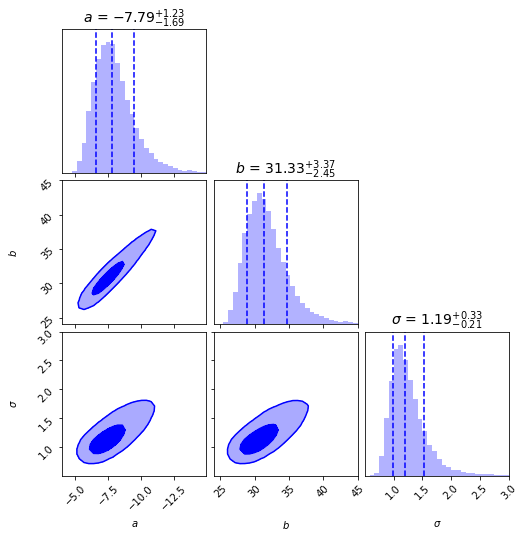

In [66]:
fig = corner.corner(mcmc_samples.T, bins=30, smooth=1,
             range=[[-4, -15], [24, 45], [0.5, 3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

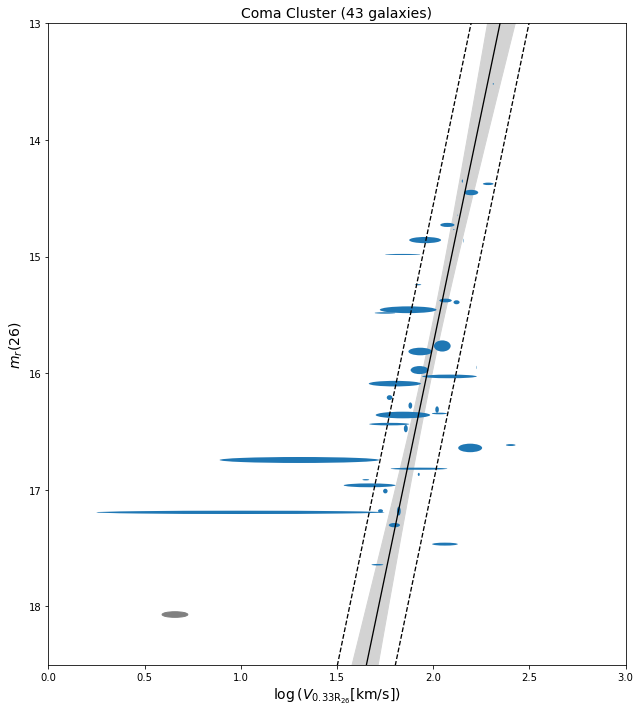

In [67]:
sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = hf.coords[0] * xvals + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright['V_0p33R26']), SGA_TF_bright['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26']
y_err = SGA_TF_bright['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs]), SGA_TF['R_MAG_SB26'][dwarfs]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs]/SGA_TF['V_0p33R26'][dwarfs]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(9,10), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    #e.set_color(cm.winter(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    #e.set_alpha(0.9)
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color('gray')
    #e.set_edgecolor('None')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150);

### Second iteration

Using `dwarfs2` sample

#### Create covariance matrix for `hyperfit`

In [71]:
Ndata = len(SGA_TF_bright2)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF_bright2['V_0p33R26_err'][i]/SGA_TF_bright2['V_0p33R26'][i])**2, 0.], 
                           [0., SGA_TF_bright2['R_MAG_SB26_ERR'][i]**2]])

#### Create `hyperfit` object

In [72]:
hf = LinFit([np.log10(SGA_TF_bright2['V_0p33R26']), SGA_TF_bright2['R_MAG_SB26']], cov)

#### Run MCMC to fit TFR

In [73]:
bounds2 = ((-20.0, 0.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples2, mcmc_lnlike2 = hf.emcee(bounds2, verbose=True)

print(np.mean(mcmc_samples2, axis=1), np.std(mcmc_samples2, axis=1))

     fun: array([-55.92026624])
     jac: array([ 0.00096847, -0.00098481,  0.00623714])
 message: 'Optimization terminated successfully.'
    nfev: 4197
     nit: 92
 success: True
       x: array([3.91141313, 0.48966228, 0.14491246])


100%|██████████| 1000/1000 [00:00<00:00, 1030.16it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [66.86285639 66.62648088 36.28778033] / 3343.1428193345064


100%|██████████| 1000/1000 [00:00<00:00, 1033.83it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.29437062 68.36234856 48.40690008] / 3464.718530987203


100%|██████████| 1000/1000 [00:00<00:00, 1048.44it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [61.49329072 60.77346187 37.70828232] / 3074.6645358283777


100%|██████████| 1000/1000 [00:00<00:00, 1034.42it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [79.33307839 78.81620601 47.62165195] / 3966.653919642216


100%|██████████| 1000/1000 [00:00<00:00, 1031.33it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [107.23023991 105.7951971   47.07512857] / 5361.5119953582225


100%|██████████| 1000/1000 [00:00<00:00, 1013.24it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [143.14410748 143.58791708  43.45467546] / 7179.395853797193


100%|██████████| 1000/1000 [00:00<00:00, 1036.66it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [122.55175199 125.15227872  50.54086669] / 6257.6139358032515


100%|██████████| 1000/1000 [00:00<00:00, 1035.59it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.19926624 115.26488574  45.92937091] / 5909.9633119877435


100%|██████████| 1000/1000 [00:00<00:00, 1032.07it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [103.00256523 101.11612202  43.38518009] / 5150.128261308234


100%|██████████| 1000/1000 [00:00<00:00, 1050.00it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [108.58044689 105.98528505  44.98937126] / 5429.022344743418


100%|██████████| 1000/1000 [00:01<00:00, 999.81it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.13163202 102.90183896  43.79255319] / 5206.581600949803
[-8.10286687 31.96098418  1.2598093 ] [1.71816891 3.42860426 0.32442983]


#### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [74]:
a2, b2, sig2    = np.median(mcmc_samples2, axis=1)
da2, db2, dsig2 = np.std(mcmc_samples2, axis=1)

for val, err in zip((a2, b2, sig2), (da2, db2, dsig2)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -7.82 +/- 1.72
 31.41 +/- 3.43
  1.20 +/- 0.32


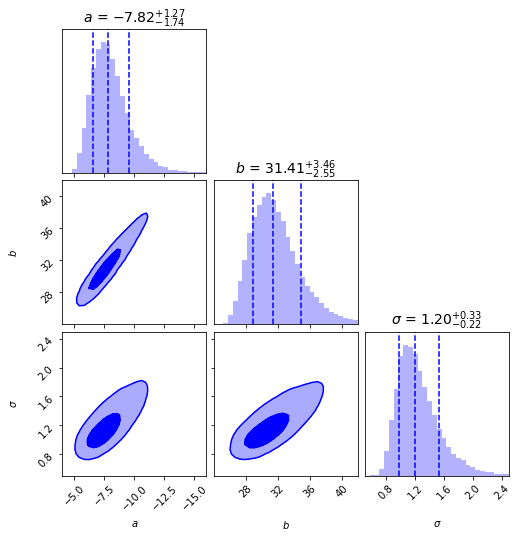

In [77]:
fig = corner.corner(mcmc_samples2.T, bins=30, smooth=1,
             range=[[-4, -16], [24, 42], [0.5, 2.5]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

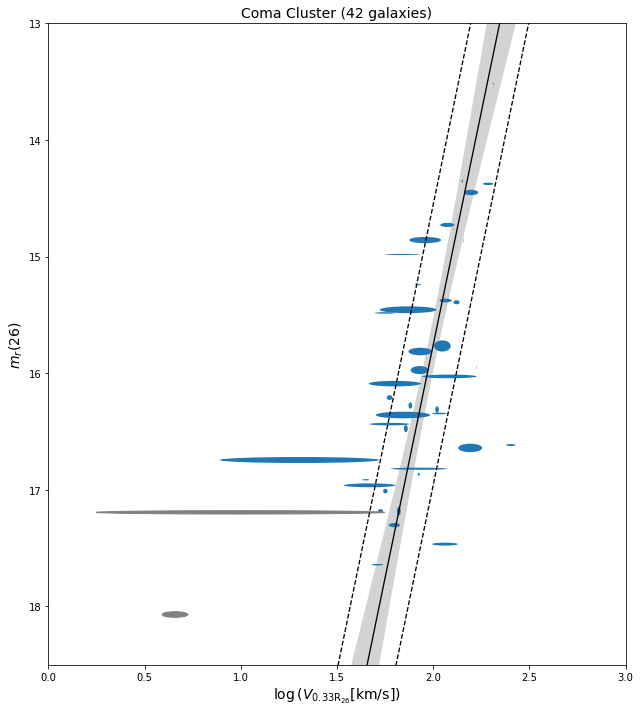

In [78]:
sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = hf.coords[0] * xvals + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples2[0]) + mcmc_samples2[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright2['V_0p33R26']), SGA_TF_bright2['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright2['V_0p33R26_err']/SGA_TF_bright2['V_0p33R26']
y_err = SGA_TF_bright2['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs2]), SGA_TF['R_MAG_SB26'][dwarfs2]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs2]/SGA_TF['V_0p33R26'][dwarfs2]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs2]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(9,10), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    #e.set_color(cm.winter(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    #e.set_alpha(0.9)
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color('gray')
    #e.set_edgecolor('None')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright2)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150)